# The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is. For every in the test set, you should predict the correct label.

In [148]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Structure
1. Data exploration.
2. Feature engineering.
3. Data Preprocessing for Model.
4. Basic model building.
5. Model tunning.
6. Ensamble model building.
7. Results.

In [149]:
training = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(f"Training size {training.shape}.")
print(f"Test size {test.shape}.")

Training size (42000, 785).
Test size (28000, 784).


In [150]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [151]:
print(training.isnull().sum()) # No null values, so no need to think how to manage them. 

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64


(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

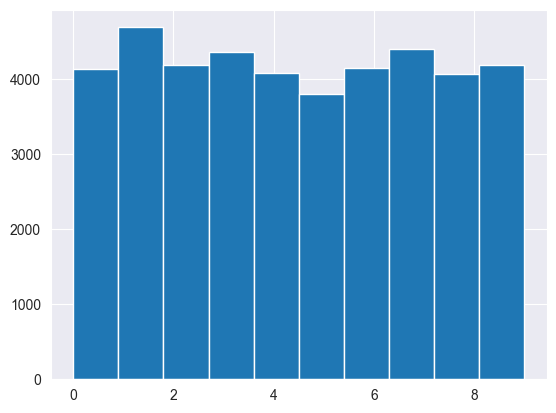

In [152]:
df_labels = training['label']
plt.hist(df_labels)

In [153]:
# The digits we have information to predict are pretty equal in terms of quantity, except number '1'. It has more but not crazy more.

## Data Preprocessing for Model.


In [154]:
X = training.drop('label', axis=1)
y = training['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_test.shape}')

X_train size: (33600, 784)
X_test size: (8400, 784)


# Basic model building.

In [155]:
model = Sequential([
    Dense(units=150, activation='relu', name='L1'),
    Dense(units=75, activation='relu', name='L2'),
    Dense(units=10, activation='linear', name='L3'),
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

model.fit(
    X_train,y_train,
    epochs=10
)

Epoch 1/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7937 - loss: 6.3416
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9205 - loss: 0.4936
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9392 - loss: 0.2876
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9491 - loss: 0.2158
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9498 - loss: 0.2016
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9598 - loss: 0.1513
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9589 - loss: 0.1402
Epoch 8/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9640 - loss: 0.1203
Epoch 9/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9677 - loss: 0.1130
Epoch 10/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9759 - loss: 0.0855


In [156]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluating the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 0.9753
Test Accuracy: 0.9521


## Complex model building 

Learning: 

The ImageDataGenerator doesn't apply all transformations to every image, nor does it choose just one. Instead, it applies a random combination of the specified transformations to each image, with each transformation applied independently. Here's how it works:
1. For each image, the generator randomly decides whether to apply each transformation.
2. If a transformation is applied, its magnitude is randomly chosen within the specified range.


## Data augmentation

In [157]:
def augment_dataset_1(X, y, num_augmented_per_image=1):
    """
    Augment the dataset by creating transformed versions of each image.
    
    Args:
    X (numpy.ndarray): Input images, shape (n_samples, 784)
    y (numpy.ndarray): Labels, shape (n_samples,)
    num_augmented_per_image (int): Number of augmented versions to create for each original image
    plot_examples (bool): If True, plot examples of original and augmented images
    
    Returns:
    tuple: (X_combined, y_combined) - Augmented dataset and corresponding labels
    """
    
    # Reshape X from (n_samples, 784) to (n_samples, 28, 28, 1)
    X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    datagen = ImageDataGenerator(
        rotation_range=10,          # Rotate images up to 10 degrees.
        zoom_range=0.1,             # Zoom in or out up to 10%. 
        width_shift_range=0.1,      # Shift horizontally up to 10% of the width.
        height_shift_range=0.1,     # Shift vertically up to 10% of the width
        shear_range=0.1,            #  Apply shear transformations up to 10%.
        fill_mode='nearest'         # Fill in newly created pixels with the nearest pixel value. 
    )

    X_augmented = []
    y_augmented = []

    for i in range(len(X)):
        img = X[i]
        label = y[i]
        img = img.reshape((1,) + img.shape)  # reshape for datagen
        
        j = 0
        for batch in datagen.flow(img, batch_size=1):
            X_augmented.append(batch[0])
            y_augmented.append(label)
            j += 1
            if j >= num_augmented_per_image:
                break

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)

    # Combine original and augmented data
    X_combined = np.concatenate((X, X_augmented), axis=0)
    y_combined = np.concatenate((y, y_augmented), axis=0)

    # Flatten the images back to (n_samples, 784)
    X_combined = X_combined.reshape(X_combined.shape[0], -1)

    return X_combined, y_combined

In [158]:
def plot_augmented_examples(X_original, X_augmented, num_examples=25):
    """
    Plot examples of original and augmented images side by side.
    """
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))
    for i in range(num_examples):
        # Plot original image
        axes[i, 0].imshow(X_original[i].reshape(28, 28), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        # Plot augmented image
        axes[i, 1].imshow(X_augmented[i].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title('Augmented')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [159]:
def augment_dataset_2(X, y, num_augmented_per_image=1, plot_examples=False):
    """
    Augment the dataset by creating transformed versions of each image.
    
    Args:
    X (numpy.ndarray): Input images, shape (n_samples, 784)
    y (numpy.ndarray): Labels, shape (n_samples,)
    num_augmented_per_image (int): Number of augmented versions to create for each original image
    plot_examples (bool): If True, plot examples of original and augmented images
    
    Returns:
    tuple: (X_combined, y_combined) - Augmented dataset and corresponding labels
    """
    # Reshape X from (n_samples, 784) to (n_samples, 28, 28, 1)
    X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # Create an ImageDataGenerator instance
    global datagen
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        fill_mode='nearest'
    )

    X_augmented = []
    y_augmented = []

    for i in range(len(X)):
        img = X[i]
        label = y[i]
        img = img.reshape((1,) + img.shape)  # reshape for datagen
        
        j = 0
        for batch in datagen.flow(img, batch_size=1):
            X_augmented.append(batch[0])
            y_augmented.append(label)
            j += 1
            if j >= num_augmented_per_image:
                break

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)

    # Combine original and augmented data
    X_combined = np.concatenate((X, X_augmented), axis=0)
    y_combined = np.concatenate((y, y_augmented), axis=0)

    # Flatten the images back to (n_samples, 784)
    X_combined = X_combined.reshape(X_combined.shape[0], -1)

    if plot_examples:
        plot_augmented_examples(X, X_augmented)

    return X_combined, y_combined

In [160]:
X = training.drop('label', axis=1).values
y = training['label'].values

# ---- Comment this to stop doing data augmentation -----
#X, y = augment_dataset(X, y, num_augmented_per_image=1)
# X, y = augment_dataset_2(X, y, num_augmented_per_image=1, plot_examples=True)
# print(f"Length X and y train: {X.shape} {y.shape}")

# Reshape the data to fit the CNN input
X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.0

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20


/Users/geronimobasso/Desktop/extra/kaggle-competitions/titanic/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.8452 - loss: 0.5093 - val_accuracy: 0.9793 - val_loss: 0.0742
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9651 - loss: 0.1155 - val_accuracy: 0.9835 - val_loss: 0.0518
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9711 - loss: 0.0909 - val_accuracy: 0.9807 - val_loss: 0.0598
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9765 - loss: 0.0750 - val_accuracy: 0.9863 - val_loss: 0.0420
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9786 - loss: 0.0682 - val_accuracy: 0.9899 - val_loss: 0.0332
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9796 - loss: 0.0644 - val_accuracy: 0.9856 - val_loss: 0.0438
Epoch 7/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9822 - loss: 0.0569 - val_accuracy: 0.9904 - val_loss: 0.0314
Epoch 8/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9834 - loss: 0.05

In [164]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 0.9988
Test Accuracy: 0.9940


In [174]:
# Obtain predictions on the test set
predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

AttributeError: 'str' object has no attribute 'predict'

### Make upload predictions

In [166]:
X = test.values

# Reshape the data to fit the CNN input
X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.0

predictions = model.predict(X) # the predictions values are not final, we need to apply softmax again in order to change them to probability.

875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [167]:
print(predictions[0])

[3.4545167e-08 1.6132262e-09 9.9999774e-01 2.7396887e-08 7.3657780e-08
 1.3640887e-09 1.5548217e-10 1.8326812e-06 1.5283629e-07 6.4723409e-08]


In [168]:
sm_preferred = tf.nn.softmax(predictions).numpy() # Now with this the values are probabilities, we need to do a final change to get the index with the highes probability in order to get the final predictions.
print(sm_preferred[0])

[0.08533677 0.08533677 0.23196888 0.08533677 0.08533677 0.08533677
 0.08533677 0.08533693 0.08533679 0.08533677]


In [169]:
predictions = np.argmax(predictions, axis=1)
print(predictions)

[2 0 9 ... 3 9 2]


In [170]:
# Create Image ID column.
image_id = []
for x in range(1, test.shape[0] + 1):
    image_id.append(x)

In [171]:
output = pd.DataFrame({'ImageId': image_id, 'Label': predictions})

model = 'cnn'
now = datetime.now()
date_time_str = now.strftime("%Y%m%d_%H%M%S")

output.to_csv(f'predictions/{model}_{date_time_str}.csv', index=False)

# Results

Got a 99.2% as the best result, final summary:

- Using more epochs makes no sense, it just over fitting the model.
- Data augmentation make not real impact so far, at least rotating images in this dataset make no significant improvement.
- Convolutional Neuronal net got the results crazy good resutls.
- Using the preferred model for the multiclass softmax appear to have been indifferent so far.
- Model evaluate function for getting accuracy was pretty useful, also the confusion matriz to understand where we were doing worst. 
- Pending: play more with the CNN parameters once I understand them. 
